In [1]:
import csv
import pandas as pd
import numpy as np
from warnings import warn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import hdbscan

from mpl_toolkits.mplot3d import Axes3D


## Прочтение pdb

In [2]:
def read_pdb(name: str) -> pd.DataFrame:
    '''
    Функция для чтения файла в формате pdb
    
    Примечание:
    * Файлу крайне не рекомендуется содержать пустые строки
    
    :param name: имя считываемого файла формата .pdb
    
    :return pdb_df: pd.DataFrame, в котором колонки соответствуют координатам каждого кислорода молекулы воды из файла
    
    '''
    w = pd.read_csv(name, sep="  ", header = None, names=[0, 1, 2, 3, 4, 5, 6, 'x', 'y', 'z', 'z1', 7, 8], engine='python')
    w.loc[(w.x.isna() == True), ['x', 'y', 'z', 
                                 'z1']] = w.loc[(w.x.isna() == True), ['x',
                                                                    'y', 'z', 'z1']].apply(lambda x: x.shift(-1), axis=1)
    pdb_df = w[['x', 'y', 'z']].astype(float)
    return pdb_df
test = read_pdb('allwater_1G45.pdb')
test.head(3)

,x,y,z
0,46.44,54.08,37.37
1,45.13,53.83,34.58
2,51.07,58.88,40.54


## Scatterplot

Визуализация с целью возыметь представление об объекте, с которым идет работа

### 2D

In [4]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(test), columns=('x', 'y', 'z'))

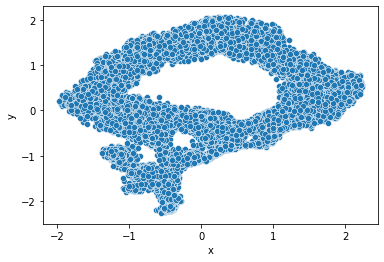

In [5]:
sns.scatterplot(data=X, x=X['x'], y=X['y'])

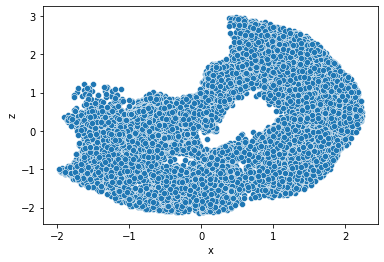

In [6]:
sns.scatterplot(data=X, x=X['x'], y=X['z'])

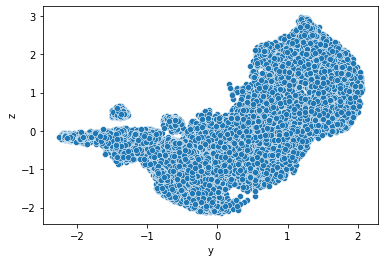

In [7]:
sns.scatterplot(data=X, x=X['y'], y=X['z'])

### 3D

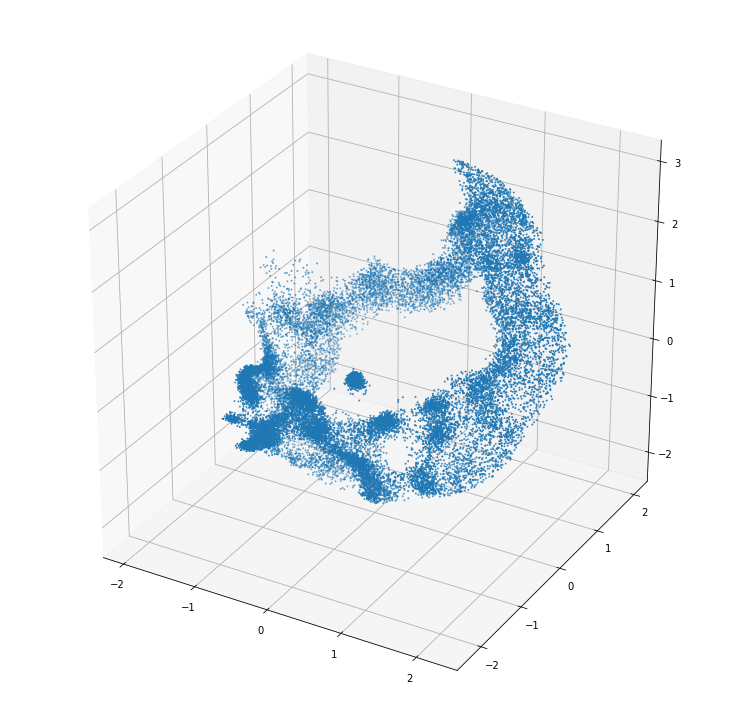

In [8]:
fig = plt.figure(figsize=(13, 13))
plt
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.x, X.y,
           X.z, s=1)

## DBSCAN after validation
Кластеризация с использованием классического алгоритма

У **DBSCAN** в применении к этой задаче есть существенная проблема: он не распознает кластеры в области низкой плотности из-за переобученности по отношению к области с высокой плотностью

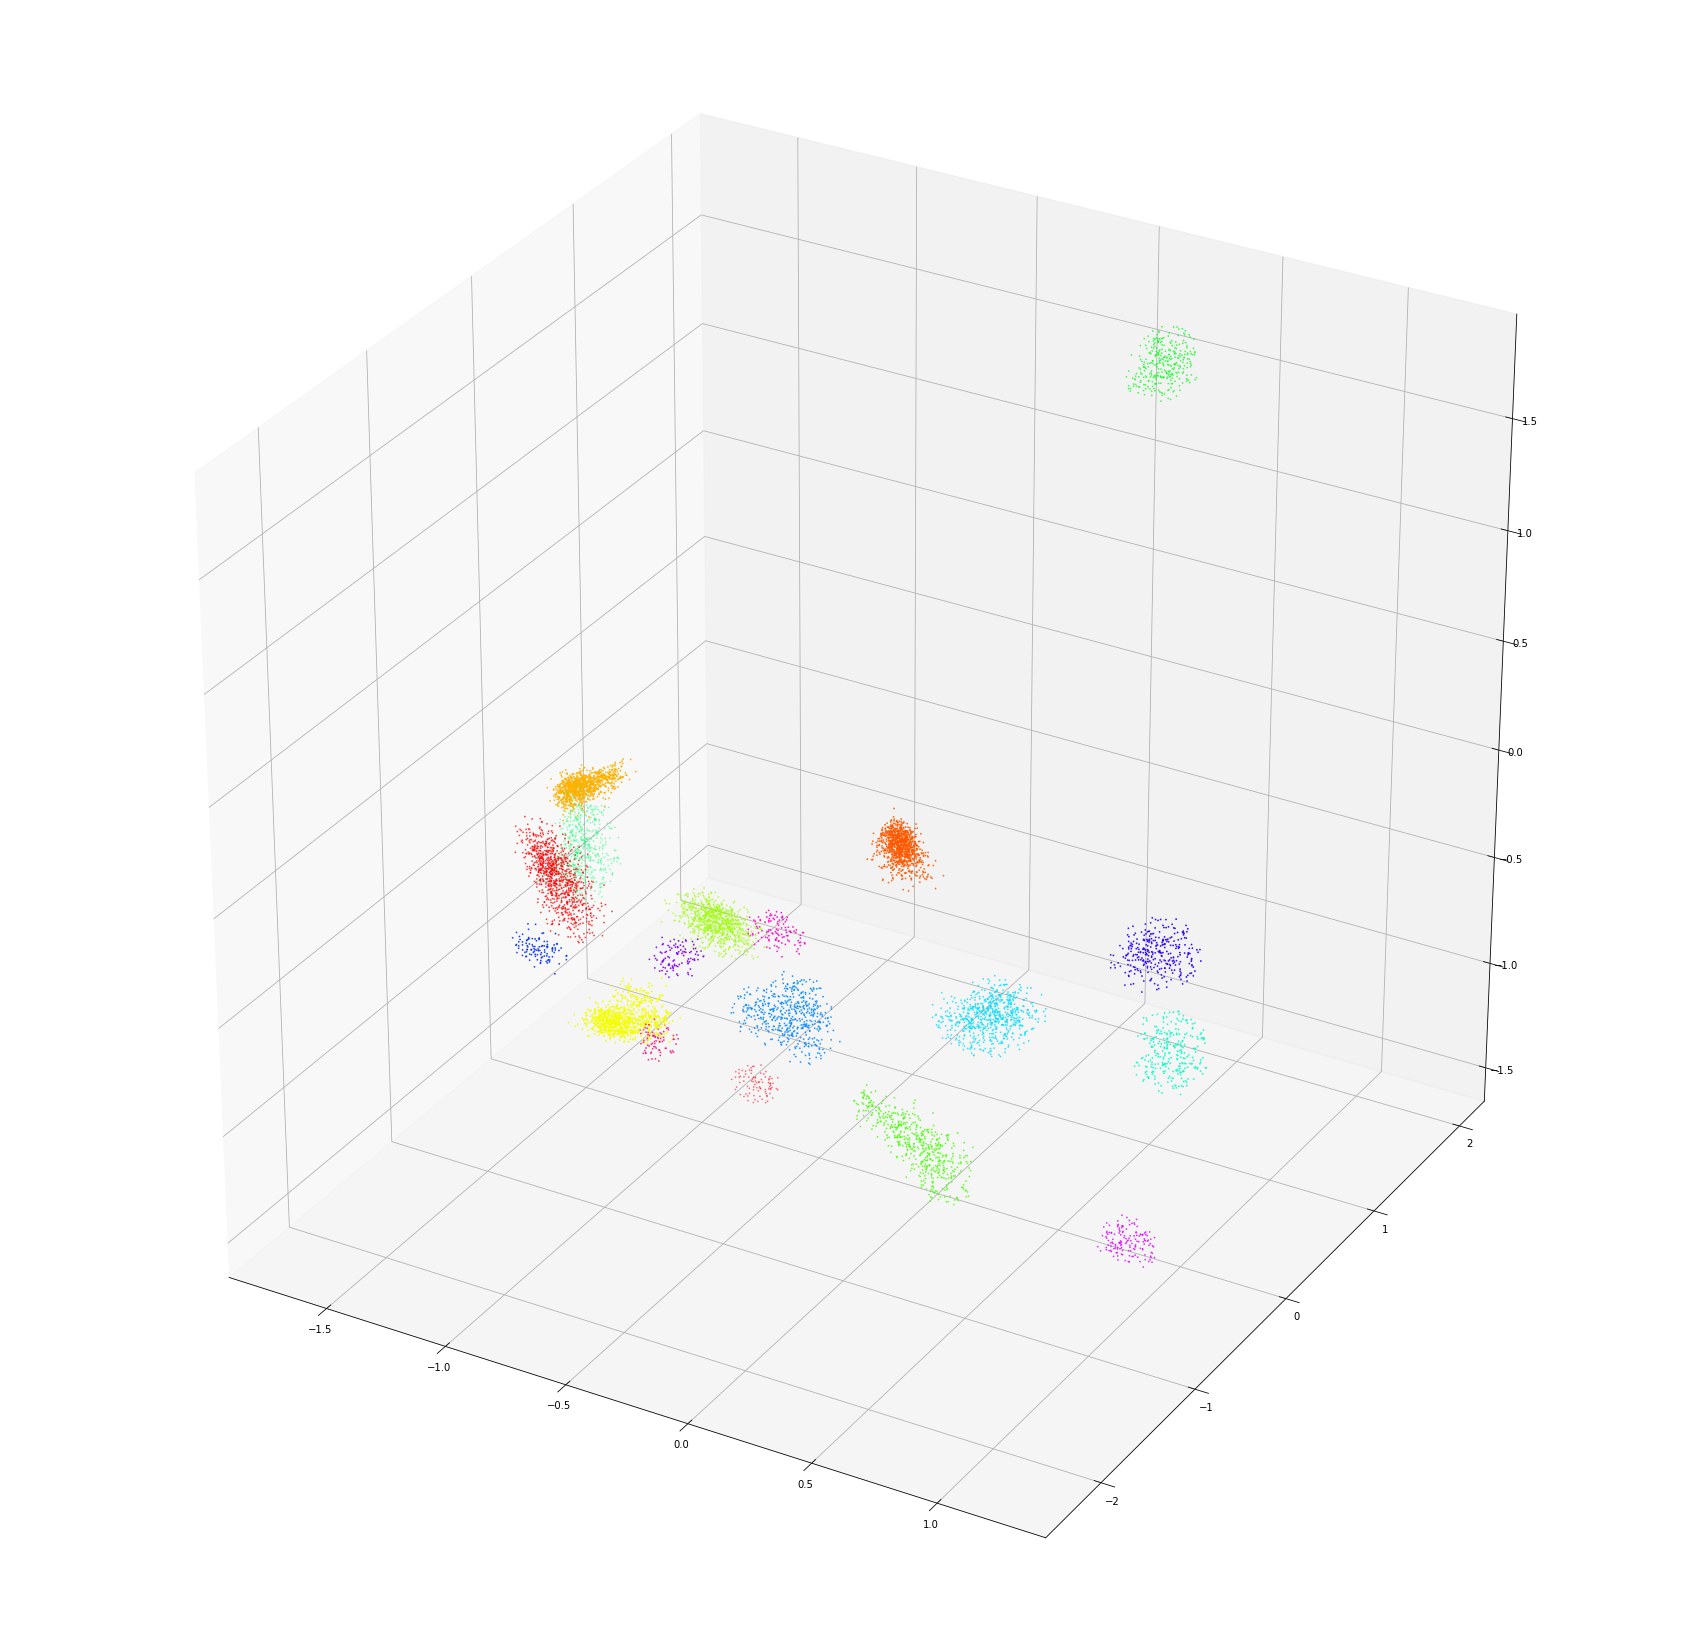

17


In [9]:
#for i in range(10, 450, 10):
#    for j in range(10, 350, 10):
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.09,
            min_samples=80,
            leaf_size=30)
db.fit(X)
(db.labels_).max()
X['cl'] = db.labels_
X_d = X[X['cl'] != -1]
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_d.x, X_d.y,
           X_d.z, c=X_d.cl, s=0.6, cmap='hsv')
plt.show()
print(X['cl'].max())

## HDBSCAN
Кластеризация с использованием иерархичного алгоритма

In [ ]:
#CV 
for i in range(50, 200, 10):
    for j in range(200, 600, 50):
        clusterer = hdbscan.HDBSCAN(min_cluster_size=i,
                                   min_samples=j,
                            cluster_selection_epsilon=0.4,
                            cluster_selection_method='leaf'
                                   )
        clusterer.fit(test)
        test['cl'] = clusterer.labels_
        train_d = test[test['cl'] != -1]
        fig = plt.figure(figsize=(30, 30))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(train_d.x, train_d.y,
                   train_d.z, c=train_d.cl, s=1, cmap='prism')
        plt.show()
        print(train_d['cl'].max(), i, j)

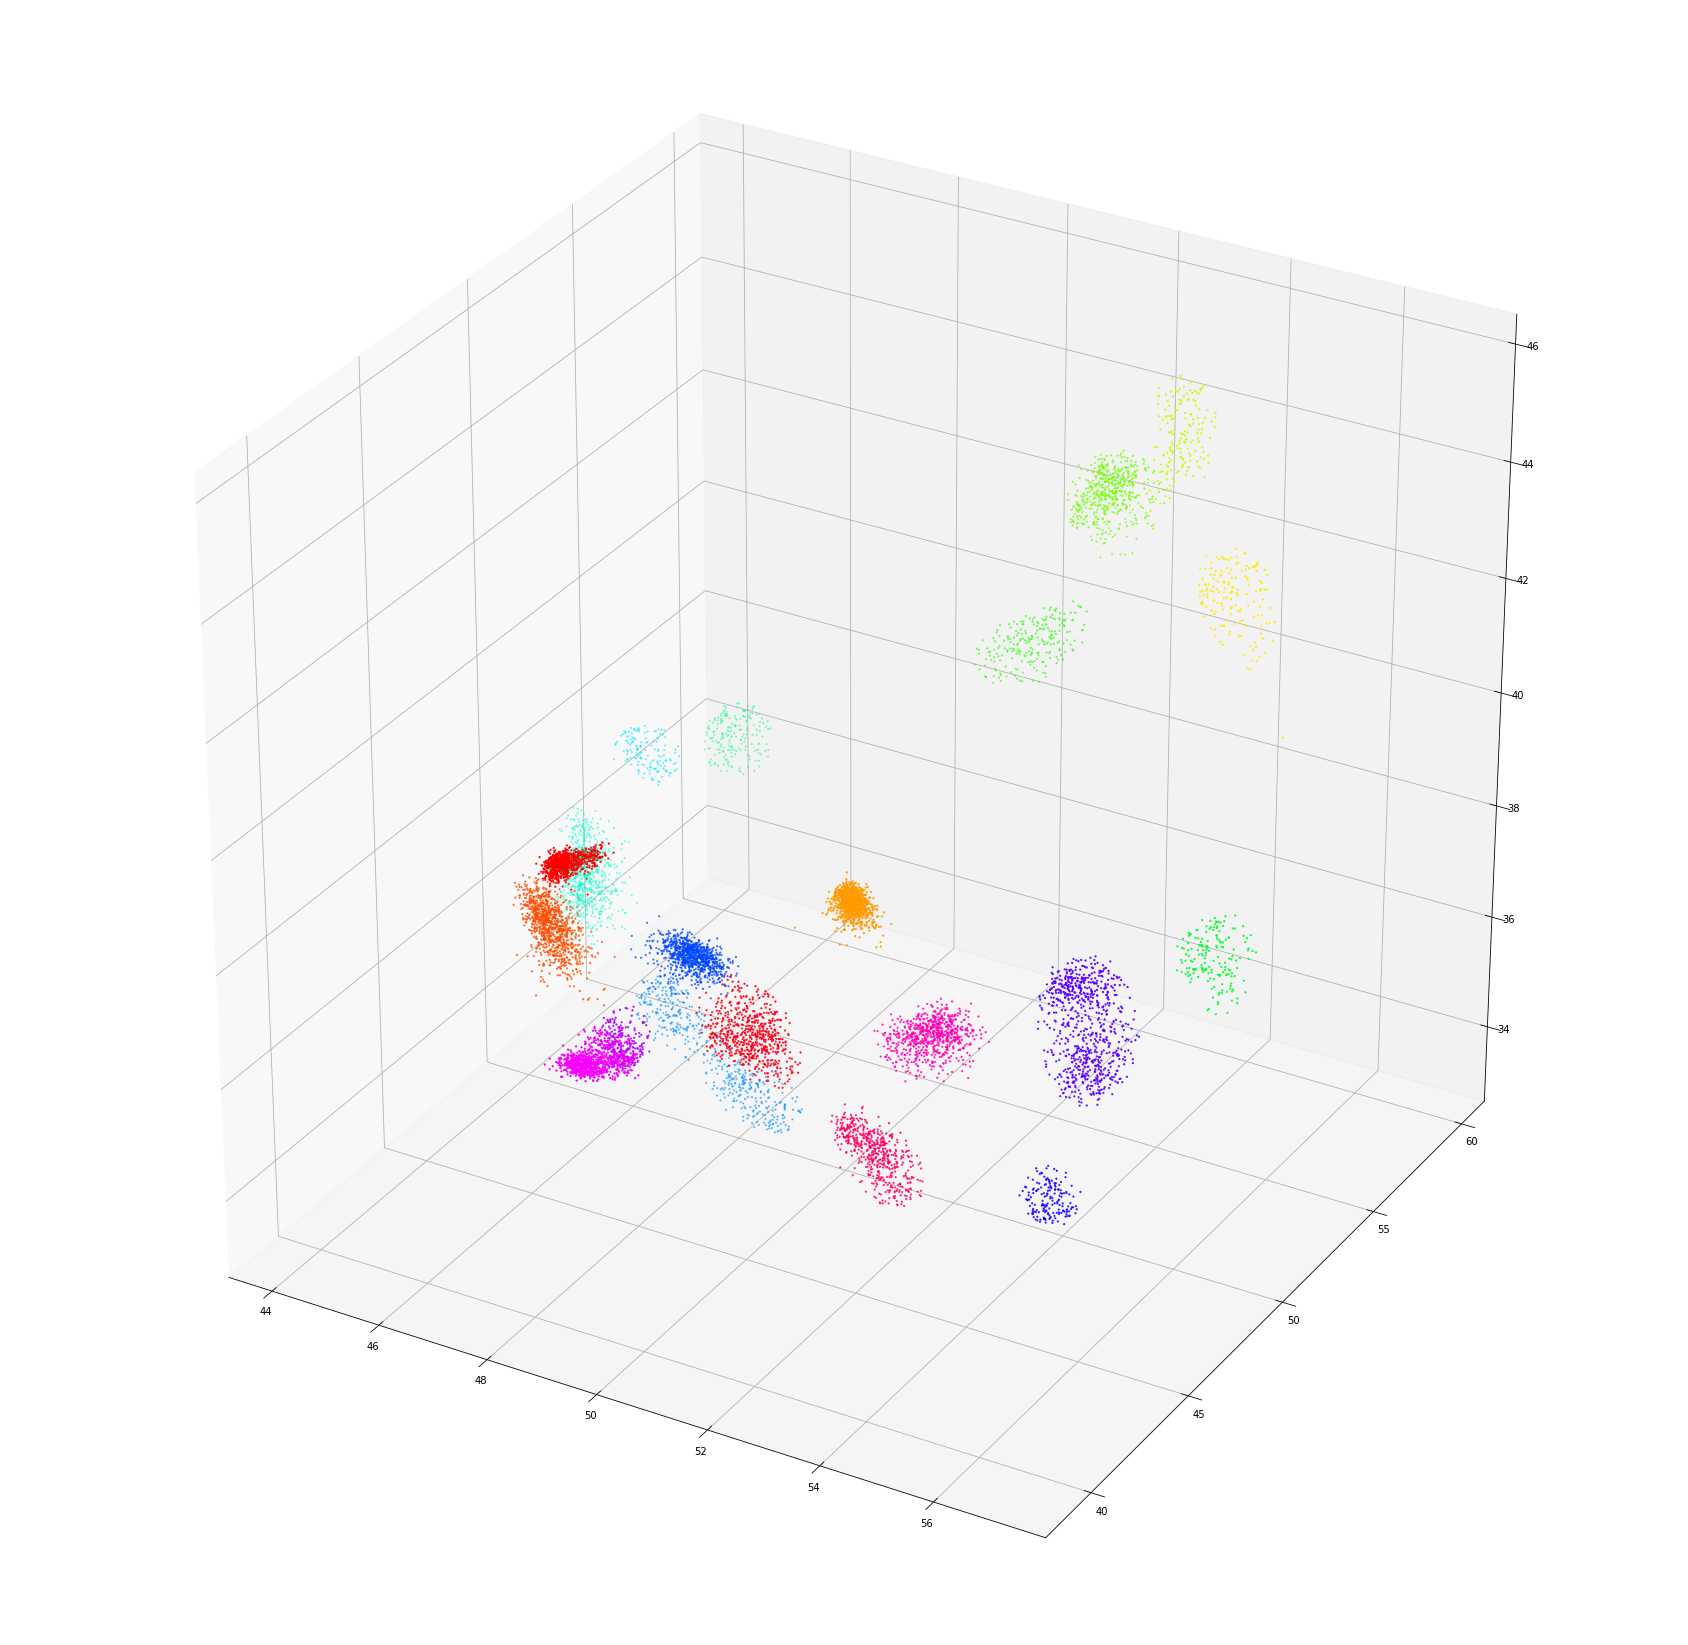

19


In [10]:
#after CV
clusterer = hdbscan.HDBSCAN(min_cluster_size=140,
                            min_samples=400,
                            cluster_selection_epsilon=0.4,
                            cluster_selection_method='leaf',
                           
                           )
clusterer.fit(test[['x', 'y', 'z']])
test['cl'] = clusterer.labels_
test_d = test[test['cl'] != -1]
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_d.x, test_d.y,
           test_d.z, c=test_d.cl, s=1.6, cmap='hsv')
plt.show()
print(test['cl'].max())

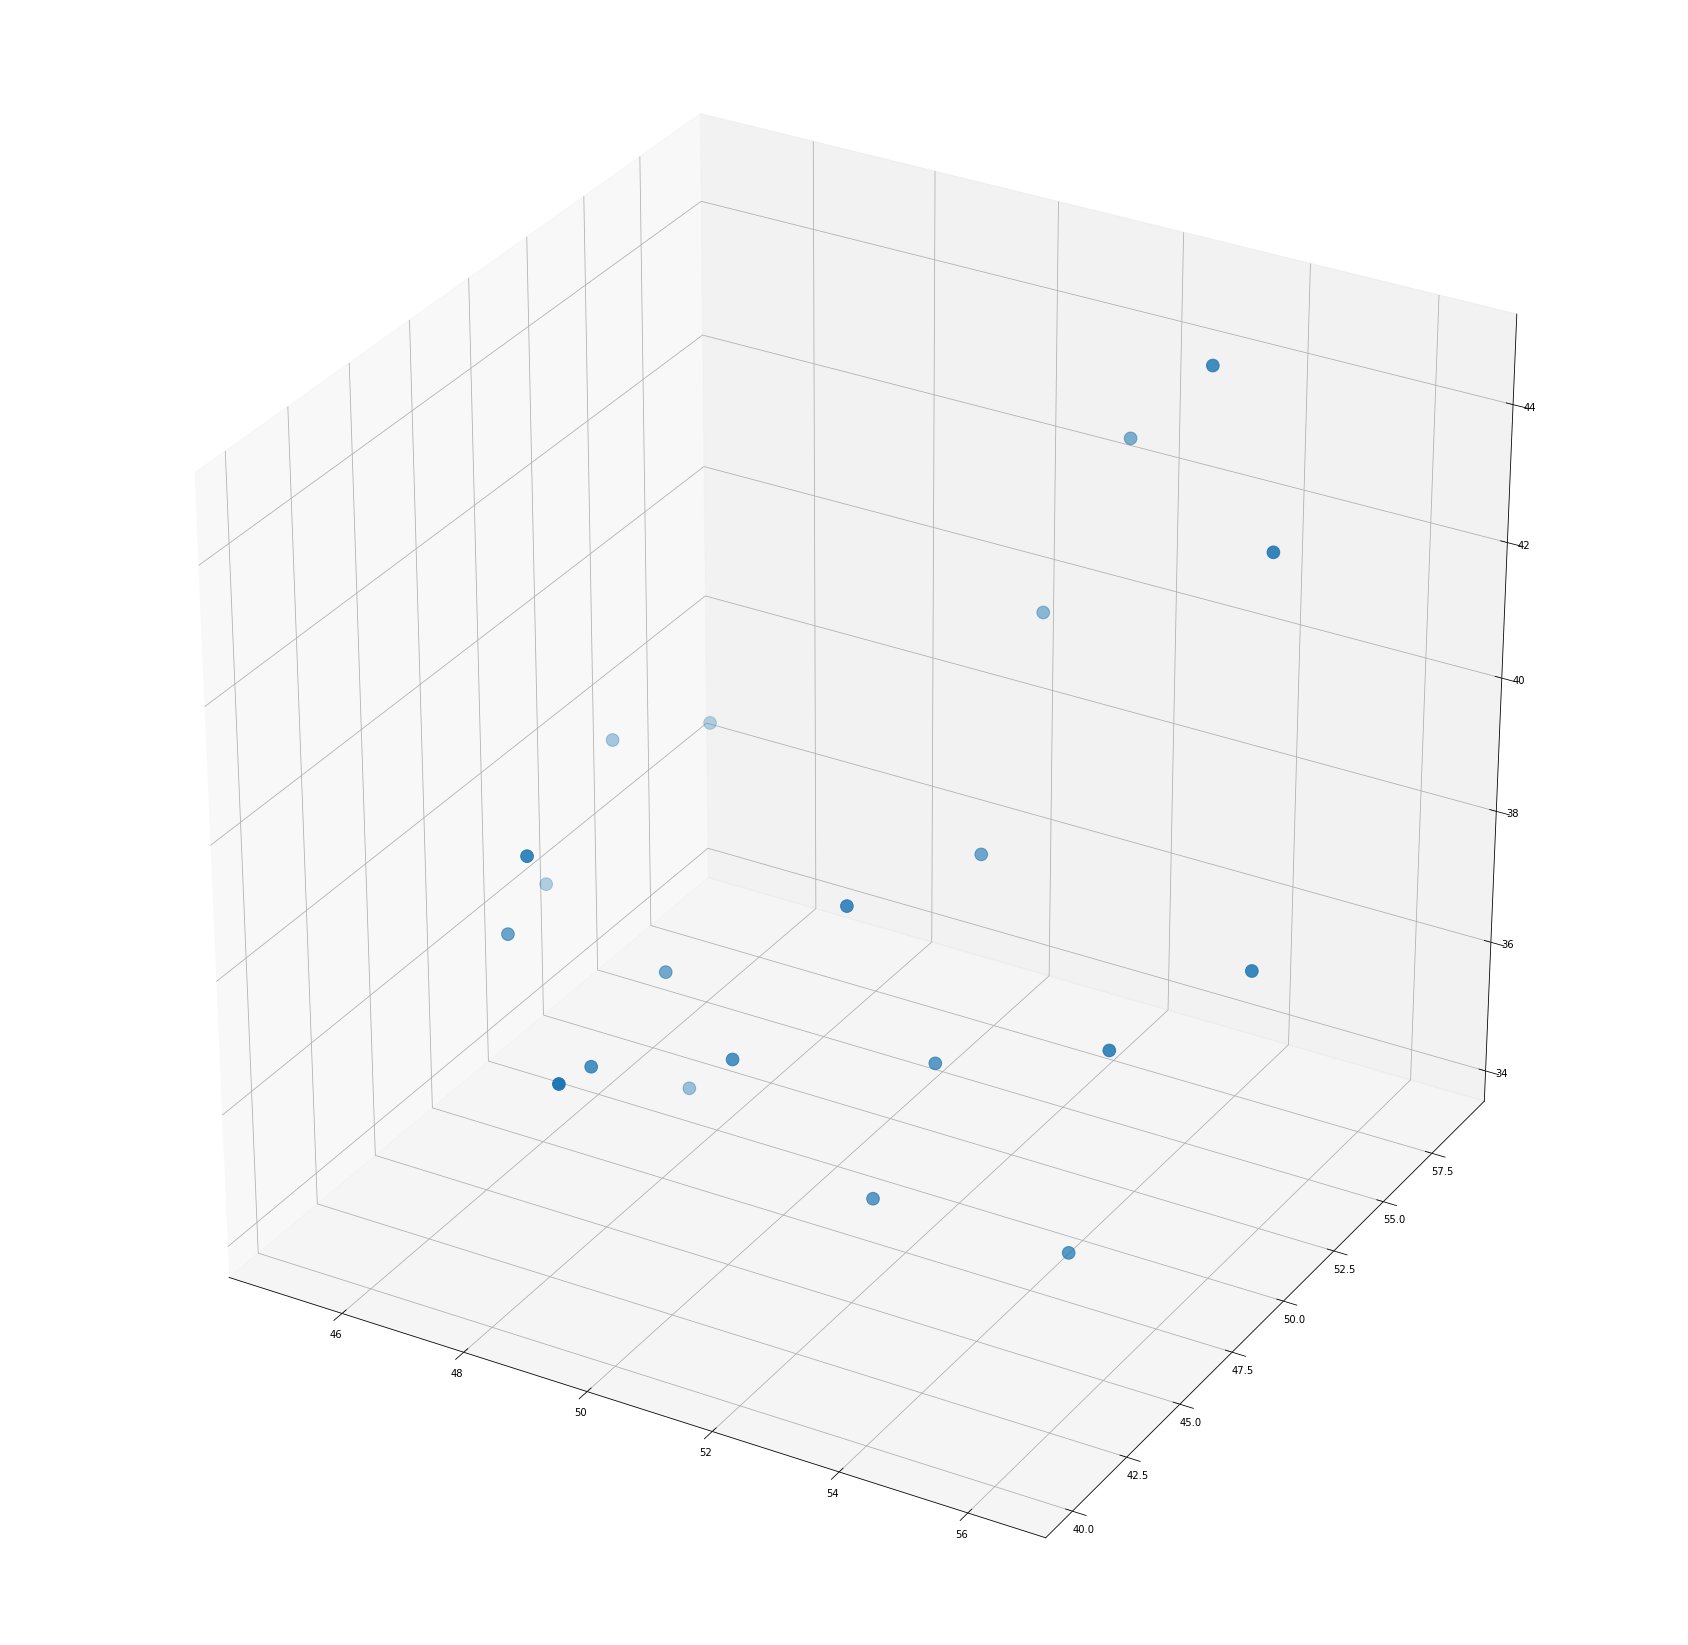

In [11]:
#center of mass
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111, projection='3d')
cent = test.groupby('cl')[['x', 'y', 'z']].mean()
ax.scatter(cent.x, cent.y,
           cent.z, s=160, cmap='hsv')
plt.show()

### Древо решения для HDBSCAN
В DBSCAN каждая ветвь была бы одинаковой из-за механизма кластеризации

(3, 0)

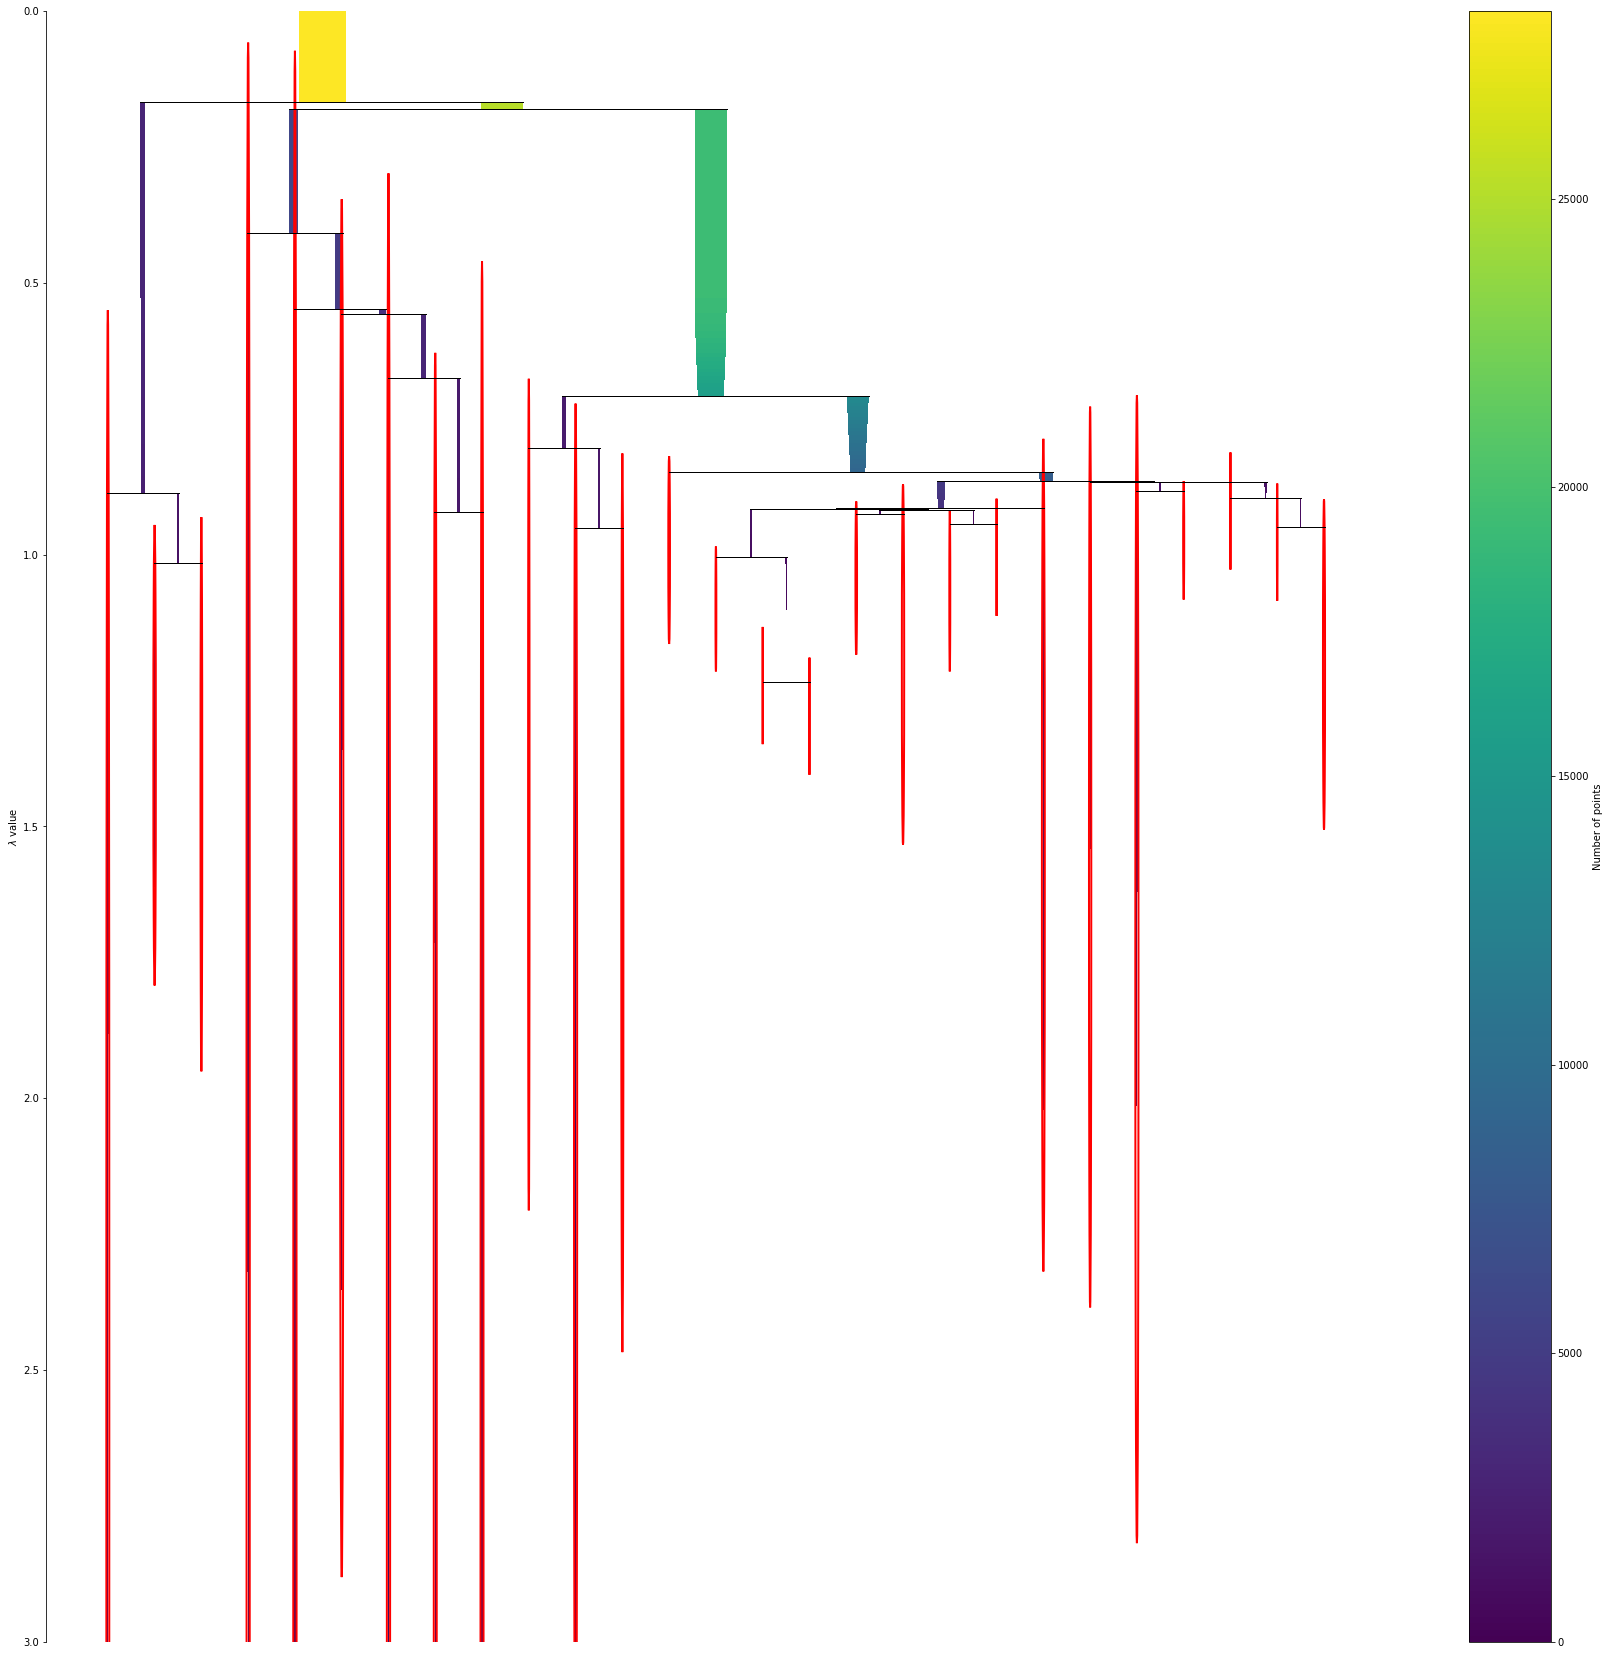

In [127]:
fig = plt.figure(figsize=(30, 30))

clusterer.condensed_tree_.plot(select_clusters=True,
    #label_clusters=True
                              )
plt.ylim(3, 0)

## Results
Сохранение файлов в формате .pdb

In [35]:
def to_pdb(x, name):
    """
    Функция для создания файла в формате pdb
    
    Примечание:
    * Должен существовать файл-оболочка для pdb с информацией об атомах

    :param x: DataFrame, содержащий информацию о координатах каждой точки и ее классе
    :param name: имя создаваемого файла формата .pdb
    
    :return None: сохраняется файл name.pdb, имеющий координаты центров масс системы
    
    """
    #pdb columns formation
    f = open('allwater.pdb')
    li = f.readlines()
    ddf = [i.split() for i in li]
    
    cent = pd.DataFrame(ddf)
    cent = cent[1:len(x['cl'].unique())]
    
    #coord formation
    cent[5] = x.groupby('cl')[['x', 'y', 'z']].mean()['x']
    cent[6] =  x.groupby('cl')[['x', 'y', 'z']].mean()['y']
    cent[7] =  x.groupby('cl')[['x', 'y', 'z']].mean()['z']
       
    #coord for pdb formation
    cent[1] = cent[1].apply(lambda x: (' '+x) if (len(str(x)) == 1) else x)
    cent[5] = cent[5].apply(lambda x: '%.3f'%(x))
    cent[6] = cent[6].apply(lambda x: '%.3f'%(x))
    cent[7] = cent[7].apply(lambda x: '%.3f'%(x))
    
    return (cent[0]+'     '+
            cent[1]+' '+
            cent[2]+'  '+
            cent[3]+' '+
            cent[4]+'      '+
            cent[5]+'  '+
            cent[6]+'  '+
            cent[7]+'  '+
            cent[8]+'  '+
            cent[9]).to_csv(f'{name}.pdb', sep=' ', index=False)

In [37]:
to_pdb(test_d, '5F61')

<!-- ![](5F61.mp4) -->
<video src="5F61.mp4" style="width: 700px;" controls></video>